## Imports

In [31]:
import pandas as pd
import glob
import json
import folium
import numpy as np
import haversine
import math
import folium
import matplotlib.pyplot as plt
import time

## Configuration

In [32]:
DATA_DIR = './data'
CONFIG_DIR = './config'

## Helper Function

In [33]:
def create_sector_shape(lon, lat, dir=0, width=120):
    p = [(lat, lon)]
    n_points = 10
    
    for a in range(n_points):
        p.append(haversine.inverse_haversine(p[0], 0.1, (dir - width/2 + width/n_points*a)/180.0 * math.pi))
    
    p.append(p[0])
    return p

def get_direction(lat1, long1, lat2, long2):
    dL = (long2 - long1)

    y = math.sin(dL) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dL)

    angle = math.atan2(y, x)
    angle = math.degrees(angle)
    angle = (angle + 360) % 360

    if angle > 180:
        angle = angle - 360
    return angle


def get_distance(lat1, lon1, lat2, lon2):
    return haversine.haversine((lat1,lon1), (lat2,lon2))*1000

## Import of Site Data

In [34]:
with open(CONFIG_DIR + '/pci2color.json', 'r') as file:
    PCI2COLOR = json.load(file)
    file.close()

with open(CONFIG_DIR + '/vodafone_fdit.json', 'r') as file:
    SITE_DICT = json.load(file)    
    file.close()

    
ANTENNA_DICT = {}

for s in SITE_DICT:
    for c in SITE_DICT[s]['cells']:
        pci = c['pci']
        ANTENNA_DICT[pci] = {}
        ANTENNA_DICT[pci]['pos'] = (SITE_DICT[s]['lat'], SITE_DICT[s]['lon'])
        ANTENNA_DICT[pci]['dir'] = c['dir_v']    
        
        
print()
print('Site Data')
print('--------------')
display(SITE_DICT)
print('--------------')


Site Data
--------------


{'30208': {'lat': 51.323418591800014,
  'lon': 12.333318509453498,
  'cells': [{'pci': 17, 'dir_v': 30, 'width_v': 35, 'earfcn': 6300},
   {'pci': 16, 'dir_v': 174, 'width_v': 35, 'earfcn': 6300},
   {'pci': 237, 'dir_v': 89, 'width_v': 35, 'earfcn': 100},
   {'pci': 238, 'dir_v': 193, 'width_v': 35, 'earfcn': 100},
   {'pci': 239, 'dir_v': 314, 'width_v': 35, 'earfcn': 100}]},
 '32564': {'lat': 51.31895021362382,
  'lon': 12.342496146727502,
  'cells': [{'pci': 335, 'dir_v': 73, 'width_v': 35, 'earfcn': 6300},
   {'pci': 371, 'dir_v': 139, 'width_v': 35, 'earfcn': 6300},
   {'pci': 142, 'dir_v': 68, 'width_v': 35, 'earfcn': 2850},
   {'pci': 61, 'dir_v': 76, 'width_v': 35, 'earfcn': 1801},
   {'pci': 403, 'dir_v': 255, 'width_v': 35, 'earfcn': 1801},
   {'pci': 154, 'dir_v': 74, 'width_v': 35, 'earfcn': 100},
   {'pci': 153, 'dir_v': 76, 'width_v': 35, 'earfcn': 100},
   {'pci': 155, 'dir_v': 100, 'width_v': 35, 'earfcn': 100},
   {'pci': 103, 'dir_v': 74, 'width_v': 35, 'earfcn': 946

--------------


## Import of Measurement Results

- CSV files are imported form the directory specified by DATA_DIR

In [35]:
DF_DICT = {}

data_files = glob.glob(DATA_DIR + '//*.csv')

for f in data_files:
    print("reading '" + f + "' ... ", end = '')
    DF_DICT[f] = pd.read_csv(f, sep=',', index_col=False)
    
    d = np.empty((DF_DICT[f].shape[0]))
    d[:] = np.nan
    DF_DICT[f]['site distance'] = d

    print(str(DF_DICT[f].shape[0]) + ' samples')
    

reading './data/hfapp_measrurement.csv' ... 2673 samples


## Calculation of Distances and Directions

- Distance to serving base station and angle relative to the antenna mainlobe direction are calculated for all PCIs within the set of imported sites

In [36]:
EVAL_PCIs = []

for s in SITE_DICT:
    for c in SITE_DICT[s]['cells']:
        EVAL_PCIs.append(c['pci'])


START_TIME = time.time()        

for f in DF_DICT:
    eval_df = DF_DICT[f]

    for i in range(eval_df.shape[0]):
        lon = eval_df.iloc[i]['lon']
        lat = eval_df.iloc[i]['lat']
        pci = eval_df.iloc[i]['pci']

        if np.isnan(lon) or np.isnan(lat) or np.isnan(pci):
            continue


        if pci in EVAL_PCIs:               
            distance = get_distance(ANTENNA_DICT[pci]['pos'][0], ANTENNA_DICT[pci]['pos'][1], lat, lon)
            eval_df.at[i, 'site distance'] = int(distance)

            direction = get_direction(ANTENNA_DICT[pci]['pos'][0], ANTENNA_DICT[pci]['pos'][1], lat, lon)
            rel_direction = (direction - ANTENNA_DICT[pci]['dir']) % 360
            if rel_direction > 180:
                rel_direction -= 360
            eval_df.at[i, 'site direction'] = int(rel_direction)

        
    print(f + ' ... %.2f seconds' % (time.time() - START_TIME))

./data/hfapp_measrurement.csv ... 0.54 seconds


## Visualization of Measurement Points and Sites

In [37]:
SITE_COLOR = '#444444'
EVAL_KPI = 'site distance'

m = folium.Map(location = [51.32736905458287, 12.335947004544213], 
                           tiles = "cartodbpositron", 
                           zoom_start = 14)


for f in DF_DICT:
    eval_df = DF_DICT[f]

    m_count = 0
    for i in range(eval_df.shape[0]):
        lon = eval_df.iloc[i]['lon']
        lat = eval_df.iloc[i]['lat']
        pci = int(eval_df.iloc[i]['pci'])
        ev = eval_df.iloc[i][EVAL_KPI]

        if np.isnan(lon) or np.isnan(lat) or np.isnan(pci):
            continue

        if m_count % 20 == 0:
            folium.Circle(radius = 10, 
                          location = [lat, lon], 
                          fill = True, 
                          color = PCI2COLOR[str(pci)], 
                          opacity = 0.9, 
                          fill_color = PCI2COLOR[str(pci)], 
                          fill_opacity = 0.9,
                          tooltip = '[' + str(pci) + '] ' + str(ev)
                         ).add_to(m)
        m_count += 1        




for s in SITE_DICT:

    pci_string = '\n'.join([str(x['pci']) for x in SITE_DICT[s]['cells']])
    dir_string = '\n'.join([str(x['dir_v']) for x in SITE_DICT[s]['cells']])
    
    site_lon = SITE_DICT[s]['lon']
    site_lat = SITE_DICT[s]['lat']
    
    folium.Circle(
        radius = 20, 
        location = [site_lat, site_lon], 
        fill = True, 
        color = SITE_COLOR, 
        opacity = 1.0, 
        fill_color = SITE_COLOR, 
        fill_opacity = 1.0,
        ).add_to(m)
    
    
    for c in SITE_DICT[s]['cells']:

        site_color = SITE_COLOR

        sector_shape = create_sector_shape(site_lon, site_lat, c['dir_v'], c['width_v'])
        sector_shape_lat = []
        sector_shape_lon = []


        for s in sector_shape:
            sector_shape_lat.append(s[0])
            sector_shape_lon.append(s[1])    


        folium.PolyLine(
            sector_shape, 
            color = SITE_COLOR,
            fill_color = PCI2COLOR[str(c['pci'])],
            fill_opacity = 0.5, 
            fill = True,
            weight = 2,
            popup = 'PCI: ' + str(c['pci']),
            tooltip = 'PCI: ' + str(c['pci'])).add_to(m)


display(m)

## Evaluation of KPI Correlation

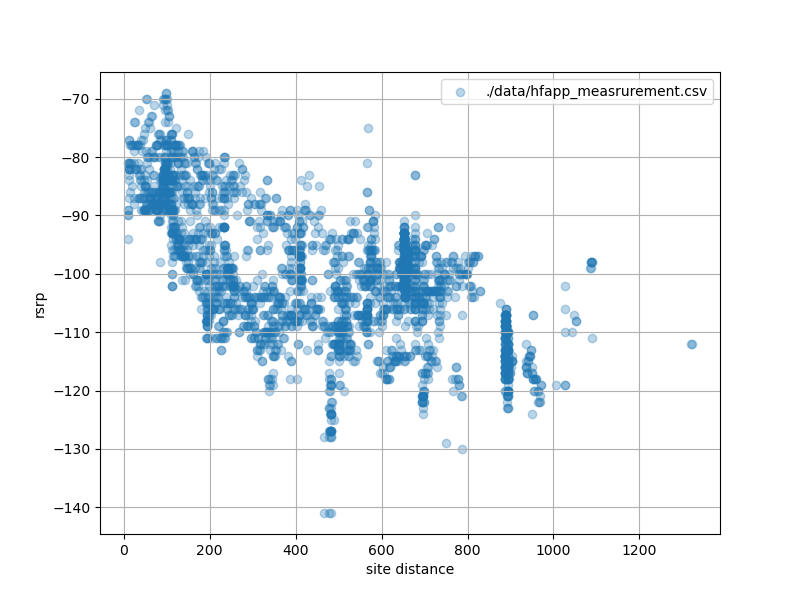

In [38]:
EVAL_KPI_X = 'site distance'
EVAL_KPI_Y = 'rsrp'

plt.figure(figsize=(8,6))

for f in DF_DICT:
    eval_df = DF_DICT[f]
    plt.scatter(eval_df[EVAL_KPI_X], eval_df[EVAL_KPI_Y], alpha=0.3, label=f)

plt.xlabel(EVAL_KPI_X)
plt.ylabel(EVAL_KPI_Y)
plt.grid()
plt.legend()

## Evaluation of KPI CDF

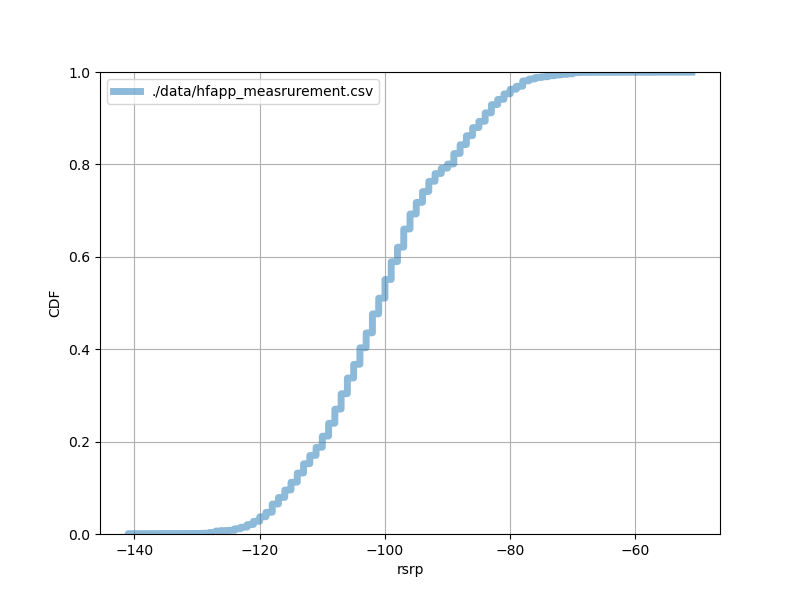

In [39]:
EVAL_KPI = 'rsrp'

plt.figure(figsize=(8,6))

for f in DF_DICT:
    eval_df = DF_DICT[f]
    data_samples = eval_df[EVAL_KPI].tolist()

    plt.plot(sorted(data_samples), np.arange(len(data_samples))/len(data_samples), linewidth=5, alpha=0.5, label=f)

plt.xlabel(EVAL_KPI)
plt.ylabel('CDF')
plt.ylim([0, 1])
plt.grid()
plt.legend()

In [40]:
display(DF_DICT['./data/hfapp_measrurement.csv'].columns)

Index(['timestamp', 'sessionID', 'datetime', 'type', 'imei', 'status', 'band',
       'mcc', 'mnc', 'pci', 'rsrp', 'rsrq', 'asu', 'rssnr', 'ta', 'cqi', 'ci',
       'lat', 'lon', 'alt', 'acc', 'speed', 'speed_acc', 'site distance',
       'site direction'],
      dtype='object')

In [41]:
plt.plot(DF_DICT['./data/hfapp_measrurement.csv']['ta'],'o')

plt.ylim([-1, 20])

(-1.0, 20.0)

In [42]:
plt.plot(DF_DICT['./data/hfapp_measrurement.csv']['rsrp'],'o')

plt.ylim([-150, -50])

(-150.0, -50.0)

In [43]:
c

{'pci': 419, 'dir_v': 281, 'width_v': 35, 'earfcn': 100}

In [44]:
plt.plot(DF_DICT['./data/hfapp_measrurement.csv']['rsrp'],DF_DICT['./data/hfapp_measrurement.csv']['ta'],'o', alpha=0.2)
#plt.xlim([0, 20])
plt.grid()
#plt.xlabel('RSRP [dBm]')
#plt.ylabel('CQI')

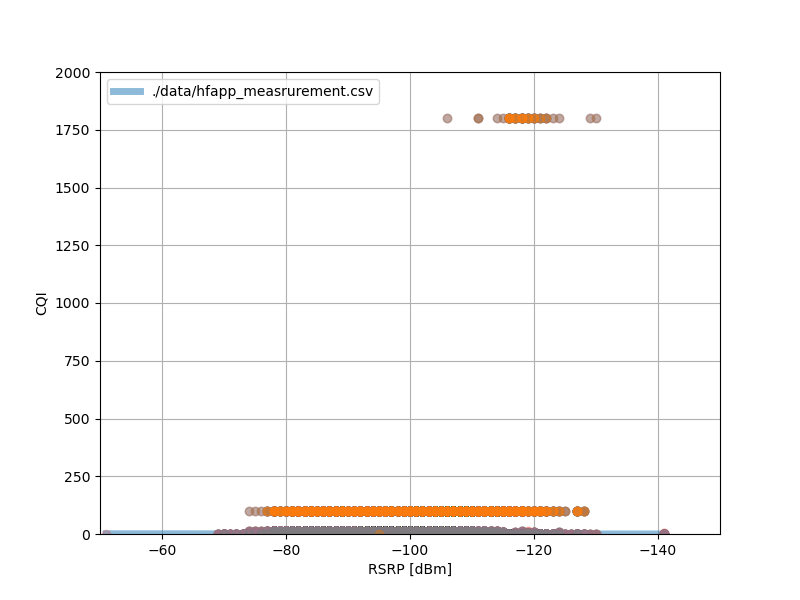

In [62]:
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')


#ax.scatter(DF_DICT['./data/hfapp_measrurement.csv']['rsrp'],DF_DICT['./data/hfapp_measrurement.csv']['cqi'],DF_DICT['./data/hfapp_measrurement.csv']['band'],'o', alpha=0.2)
plt.plot(DF_DICT['./data/hfapp_measrurement.csv']['rsrp'],DF_DICT['./data/hfapp_measrurement.csv']['band'],'o', alpha=0.2)
plt.ylim([0, 2000])
plt.xlim([-50, -150])
plt.grid()
plt.xlabel('RSRP [dBm]')
plt.ylabel('CQI')



plt.show()